# Benchmarking CPU vs GPU en TensorFlow

En esta práctica vamos a comparar el rendimiento de la CPU y la GPU en TensorFlow. 
Para ello vamos a entrenar el mismo modelo de Deep Learning y vamos a medir el 
tiempo que tarda cada dispositivo en realizarlas.

Los pasos que vamos a seguir son los siguientes:
1. Importar las librerías necesarias
2. Comprobar que TensorFlow es capaz de encontrar y usar la GPU
3. Cargar el dataset [MNIST](https://en.wikipedia.org/wiki/MNIST_database)
4. Definir la arquitectura de la red neuronal
5. Entrenar el modelo para distintos batch_sizes en CPU y medir el tiempo
6. Entrenar el modelo para distintos batch_sizes en GPU y medir el tiempo

## Importación de librerías

Vamos a emplear el conocido framework de Deep Learning [TensorFlow](https://www.tensorflow.org/).

In [9]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

import numpy as np                                
import matplotlib.pyplot as plt
import tensorflow.keras as k
# from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import time

2.12.0


In [10]:
tf.config.experimental.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Comprobación de la GPU

Vamos a asegurarnos de que nuestro sistema es capaz de encontrar la GPU y de que
TensorFlow es capaz de usarla.

In [11]:
!nvidia-smi

"nvidia-smi" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


En la siguiente celda se muestra información sobre la GPU que tenemos disponible.

El output debe ser: 

**1 Physical GPUs, 1 Logical GPUs**

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## Carga del dataset

El MNIST dataset es un dataset de imágenes de dígitos escritos a mano. En tensorflow
tenemos una función que nos permite cargarlo y dividirlo en los conjuntos de train y test.

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28,28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_test=x_test.astype('float32')
x_train=x_train.astype('float32')
mean=np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std
x_train = (x_train-mean)/std

print("counts of x_train : {}, y_train : {}, x_test : {}, y_test : {}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))

counts of x_train : 60000, y_train : 60000, x_test : 10000, y_test : 10000


In [14]:
num_classes=10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("counts of x_train : {}, y_train : {}, x_test : {}, y_test : {}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))

counts of x_train : 60000, y_train : 60000, x_test : 10000, y_test : 10000


## Definición de la arquitectura del modelo

En este caso, como se trata de un problema de clasificación de imágenes, vamos a
definir una red neuronal convolucional.

Constará de:
- Una capa de entrada (las imágenes de 28x28 píxeles)
- Dos capas convolucionales con 32 filtros de 3x3
- Una capa de pooling de 2x2
- Dos capas convolucionales con 64 filtros de 3x3
- Una capa de pooling de 2x2
- Una capa oculta
- Una capa de salida de 10 neuronas (una por cada clase)

In [15]:
def get_model():
    # don't change anything
    num_filter=32
    num_dense=512
    drop_dense=0.7
    ac='relu'
    learningrate=0.01

# with tf.device("/cpu:0"):
    model = Sequential()

    model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

    model.add(Flatten())                        
    model.add(Dense(num_dense, activation=ac))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.SGD()

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optimizer)
    return model

# Entrenamiento del modelo en CPU

Empezamos entrenando el modelo en CPU. Vamos a medir el tiempo que tarda en entrenar
y guardarlo en una lista para poder representarlo versus el batch_size.

In [17]:
cpu_list=[]
batch_sizes = []
with tf.device("/cpu:0"):
    for i in range(0, 4):
        k=2**(7 + i)
        print("batch size "+str(k))
        model = get_model()
        t1 = time.time()
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))
        t2 = time.time()
        cpu_list.append(int(t2-t1))
        batch_sizes.append(k)

batch size 128
299/469 [==================>...........] - ETA: 54s - loss: 0.3941 - accuracy: 0.8839

KeyboardInterrupt: 

In [ ]:
print(cpu_list)

[281, 252, 235, 235, 223, 220, 239]


El tiempo promedio de entrenamiento, por tanto, es:

In [13]:
cpu_score = sum(cpu_list)/len(cpu_list)
cpu_score

240.71428571428572

# Entrenamiento del modelo en GPU

In [14]:
!nvidia-smi

Fri Aug 13 14:44:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |    369MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
gpu_list=[]
batch_sizes = []
print("gpu_list : ", gpu_list)
with tf.device("/gpu:0"):
    for i in range(0, 4):
        k=2**(7 + i)
        print("batch size "+str(k))
        model = get_model()
        t1 = time.time()
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))
        t2 = time.time()
        gpu_list.append(int(t2-t1))
        batch_sizes.append(k)

gpu_list :  []
batch size 8
7500/7500 [==============================] - 39s 4ms/step - loss: 0.4000 - accuracy: 0.8823 - val_loss: 0.0549 - val_accuracy: 0.9817
batch size 16
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0697 - accuracy: 0.9791 - val_loss: 0.0235 - val_accuracy: 0.9912
batch size 32
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0440 - accuracy: 0.9868 - val_loss: 0.0210 - val_accuracy: 0.9925
batch size 64
938/938 [==============================] - 6s 7ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.0189 - val_accuracy: 0.9933
batch size 128
469/469 [==============================] - 4s 9ms/step - loss: 0.0304 - accuracy: 0.9908 - val_loss: 0.0185 - val_accuracy: 0.9935
batch size 256
235/235 [==============================] - 3s 14ms/step - loss: 0.0277 - accuracy: 0.9914 - val_loss: 0.0180 - val_accuracy: 0.9933
batch size 512
118/118 [==============================] - 3s 23ms/step - loss: 0.0263 - accuracy: 0.9921

In [17]:
gpu_list

[38, 20, 13, 6, 4, 3, 3]

Como podemos apreciar, el entrenamiento en GPU es mucho más rápido que en CPU.

In [18]:
gpu_score = sum(gpu_list)/len(gpu_list)
gpu_score

12.428571428571429

## Comparación gráfica

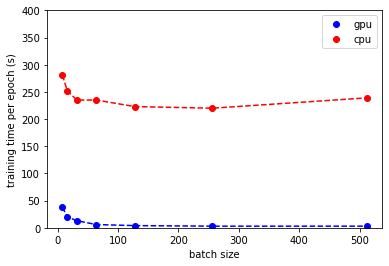

In [19]:
plt.plot(batch_sizes,gpu_list,'bo')
plt.plot(batch_sizes,cpu_list,'ro')
plt.plot(batch_sizes,gpu_list,'b--')
plt.plot(batch_sizes,cpu_list,'r--')
plt.ylabel('training time per epoch (s)')
plt.xlabel('batch size')
plt.legend(['gpu', 'cpu'], loc='upper right')
plt.ylim([0,400])
plt.savefig('CPUvsGPU.png') 
plt.show()